In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA

In [410]:
#Data Read
df_istanbul = pd.read_csv('/Users/iremn/PythonClass/Spiced/Personal_Projects/Weather/ECA_blended_custom/TG_STAID000248.txt', header = 14)

In [411]:
df_istanbul.columns = ['Source ID', 'Date', 'Mean Temp*10', 'Qual']

In [412]:
df_istanbul['Date'] = pd.to_datetime(df_istanbul['Date'], format="%Y%m%d")

In [413]:
#New DF from Suspect
df_istanbul_suspect = df_istanbul[df_istanbul['Qual'] == 1]


In [414]:
#Remove data Qual = 9
df_istanbul = df_istanbul[df_istanbul['Qual'] != 9]


In [415]:
df_istanbul['Real_temp'] = df_istanbul['Mean Temp*10']/10

In [416]:
df_istanbul.tail()

,Source ID,Date,Mean Temp*10,Qual,Real_temp
27419,101231,2004-01-27,36,0,3.6
27420,101231,2004-01-28,85,0,8.5
27421,101231,2004-01-29,128,0,12.8
27422,101231,2004-01-30,78,0,7.8
27423,101231,2004-01-31,46,0,4.6


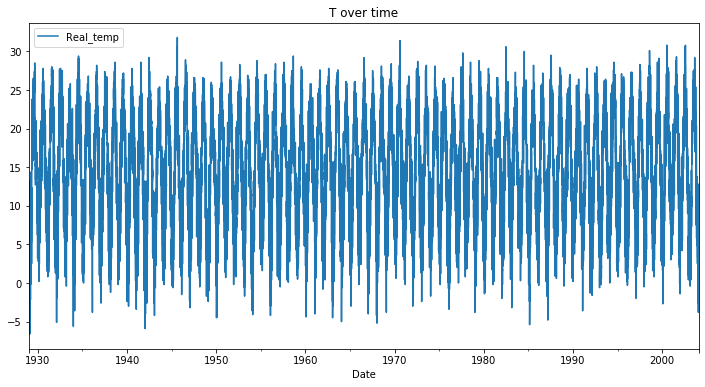

In [417]:
#Plot
df_istanbul.plot(x = 'Date', y= 'Real_temp', figsize=(12,6), title='T over time')


# De-trend this 

In [418]:
#Linear
df_istanbul['lin_difference'] = df_istanbul['Real_temp'].diff()
df_istanbul.head()

,Source ID,Date,Mean Temp*10,Qual,Real_temp,lin_difference
0,101231,1929-01-01,126,0,12.6,NaN
1,101231,1929-01-02,133,0,13.3,0.7
2,101231,1929-01-03,131,0,13.1,-0.2
3,101231,1929-01-04,118,0,11.8,-1.3
4,101231,1929-01-05,106,0,10.6,-1.2


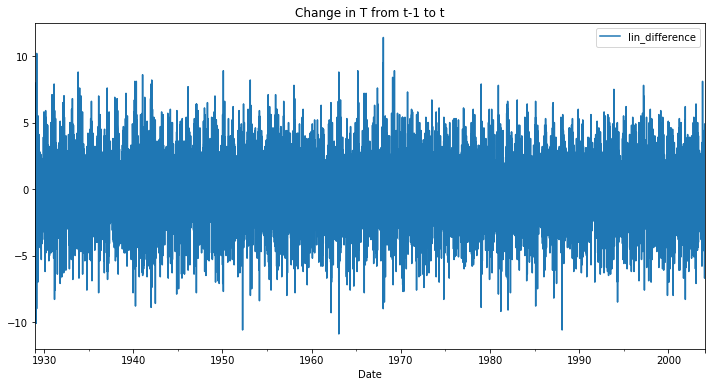

In [419]:
df_istanbul.plot(x = 'Date', y= 'lin_difference',figsize=(12,6), title='Change in T from t-1 to t')
plt.show()

In [420]:
#Check if it is linear
df_istanbul['lin_difference'].mean() # so it is linear - there is no exponential increase

-0.00029172592349487807

# By rolling mean #

In [421]:
df_istanbul['rolling_mean'] = df_istanbul['Real_temp'].rolling(365, center=True).mean()
df_istanbul.head()

,Source ID,Date,Mean Temp*10,Qual,Real_temp,lin_difference,rolling_mean
0,101231,1929-01-01,126,0,12.6,NaN,NaN
1,101231,1929-01-02,133,0,13.3,0.7,NaN
2,101231,1929-01-03,131,0,13.1,-0.2,NaN
3,101231,1929-01-04,118,0,11.8,-1.3,NaN
4,101231,1929-01-05,106,0,10.6,-1.2,NaN


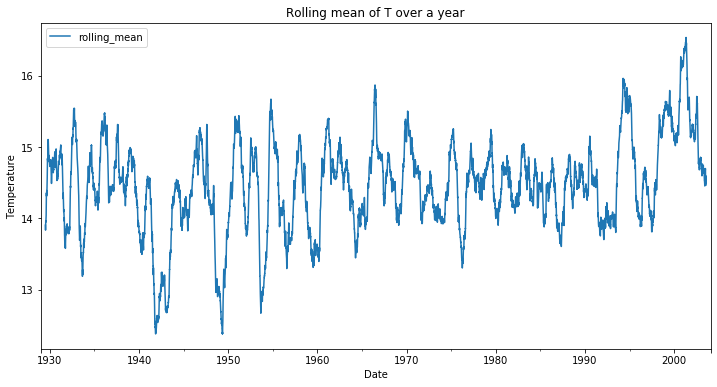

In [422]:
df_istanbul.plot(x = 'Date', y= ['rolling_mean'], figsize=(12, 6))
plt.title('Rolling mean of T over a year')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.show()

In [423]:
df_istanbul['de-trended'] = df_istanbul['Real_temp'] - df_istanbul['rolling_mean']
df_istanbul.head()

,Source ID,Date,Mean Temp*10,Qual,Real_temp,lin_difference,rolling_mean,de-trended
0,101231,1929-01-01,126,0,12.6,NaN,NaN,NaN
1,101231,1929-01-02,133,0,13.3,0.7,NaN,NaN
2,101231,1929-01-03,131,0,13.1,-0.2,NaN,NaN
3,101231,1929-01-04,118,0,11.8,-1.3,NaN,NaN
4,101231,1929-01-05,106,0,10.6,-1.2,NaN,NaN


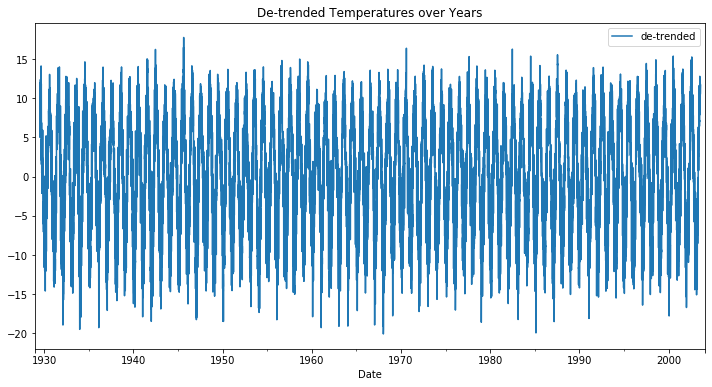

In [424]:
#Plot
df_istanbul.plot(x = 'Date', y= 'de-trended',figsize=(12,6), title='De-trended Temperatures over Years')


# Remove change in volatility if any

In [425]:
df_istanbul['log_y'] = np.log(df_istanbul['Real_temp'])
df_istanbul['log_diff'] = df_istanbul.log_y.diff()
df_istanbul.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/pandas/core/algorithms.py:1819: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,Source ID,Date,Mean Temp*10,Qual,Real_temp,lin_difference,rolling_mean,de-trended,log_y,log_diff
0,101231,1929-01-01,126,0,12.6,NaN,NaN,NaN,2.533697,NaN
1,101231,1929-01-02,133,0,13.3,0.7,NaN,NaN,2.587764,0.054067
2,101231,1929-01-03,131,0,13.1,-0.2,NaN,NaN,2.572612,-0.015152
3,101231,1929-01-04,118,0,11.8,-1.3,NaN,NaN,2.468100,-0.104513
4,101231,1929-01-05,106,0,10.6,-1.2,NaN,NaN,2.360854,-0.107246


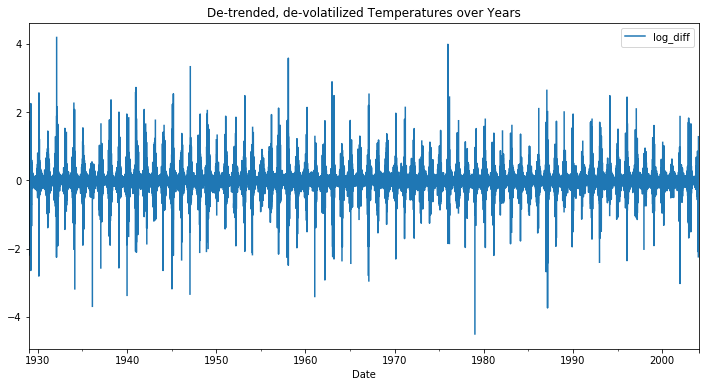

In [426]:
#Plot
df_istanbul.plot(x = 'Date', y= 'log_diff',figsize=(12,6), title='De-trended, de-volatilized Temperatures over Years')

In [427]:
#Make a month column

In [428]:
df_istanbul['Month'] = df_istanbul['Date'].dt.month

# Take out the seasonality by grouping in months 

In [429]:
df_istanbul['monthly_mean'] = df_istanbul.groupby('Month')['log_diff'].transform('mean')


In [430]:
df_istanbul['de-seasonalized'] = df_istanbul['log_diff'] - df_istanbul['monthly_mean']

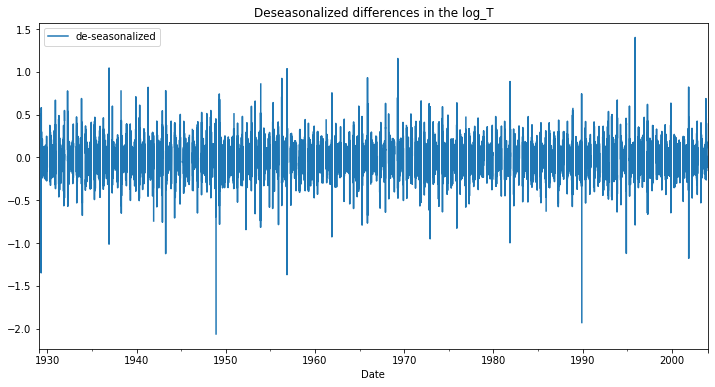

In [431]:
df_istanbul.plot(x='Date', y ='de-seasonalized', figsize=(12,6), title='Deseasonalized differences in the log_T')

In [432]:
from statsmodels.tsa.seasonal import seasonal_decompose

Figure(432x288)


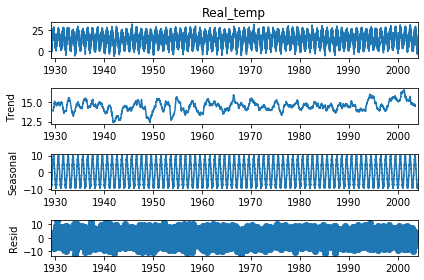

In [433]:
df_istanbul_reind = df_istanbul.set_index('Date')
decompose = seasonal_decompose(df_istanbul_reind['Real_temp'], model='additive', period=365)
print(decompose.plot())

# Is it centeralized around normal? (ie zero and a symmetric distribution) 

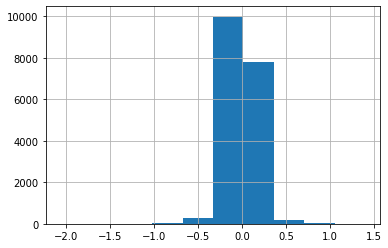

In [434]:
df_istanbul['de-seasonalized'].hist(bins=10)

### Train Test Split

In [435]:
df_istanbul.set_index('Date', inplace = True)

In [436]:
df_istanbul.head()

,Source ID,Mean Temp*10,Qual,Real_temp,lin_difference,rolling_mean,de-trended,log_y,log_diff,Month,monthly_mean,de-seasonalized
Date,,,,,,,,,,,,
1929-01-01,101231,126,0,12.6,NaN,NaN,NaN,2.533697,NaN,1,NaN,NaN
1929-01-02,101231,133,0,13.3,0.7,NaN,NaN,2.587764,0.054067,1,NaN,NaN
1929-01-03,101231,131,0,13.1,-0.2,NaN,NaN,2.572612,-0.015152,1,NaN,NaN
1929-01-04,101231,118,0,11.8,-1.3,NaN,NaN,2.468100,-0.104513,1,NaN,NaN
1929-01-05,101231,106,0,10.6,-1.2,NaN,NaN,2.360854,-0.107246,1,NaN,NaN


In [437]:
# Split it into train and test
y_train_temp = df_istanbul.loc[:'2000-01-01'].Real_temp
y_test_temp = df_istanbul.loc['2000-01-01':].Real_temp

len(y_train_temp), len(y_test_temp)

(25933, 1492)

Figure(432x288)


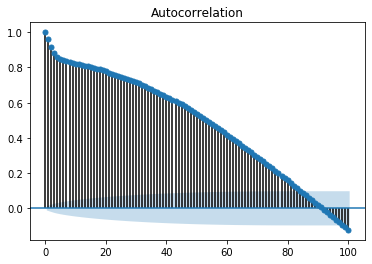

In [438]:
print(plot_acf(y_train_temp, lags=100))

Figure(432x288)


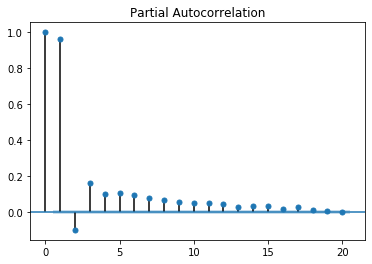

In [439]:
print(plot_pacf(y_train_temp, lags=20))

## AutoReg fit - Non-Stationary

In [440]:
# Fit the model
ar_T = AutoReg(y_train_temp, lags=2)
res_T = ar_T.fit()
print(res_T.summary())

                            AutoReg Model Results                             
Dep. Variable:              Real_temp   No. Observations:                25933
Model:                     AutoReg(2)   Log Likelihood              -54736.502
Method:               Conditional MLE   S.D. of innovations              1.998
Date:                Wed, 29 Apr 2020   AIC                              1.384
Time:                        22:34:18   BIC                              1.385
Sample:                    01-03-1929   HQIC                             1.385
                         - 01-01-2000                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.6293      0.028     22.493      0.000       0.574       0.684
Real_temp.L1     1.0573      0.006    171.126      0.000       1.045       1.069
Real_temp.L2    -0.1010      0.006    -16.34

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [441]:
parameters = res_T.params

In [442]:
parameters

intercept       0.629258
Real_temp.L1    1.057257
Real_temp.L2   -0.100961
dtype: float64

In [444]:
## construct walk-forward forecast

# create an empty list of predictions
predictions = []

# create a loop to predict the value for every timestep in y_test
for i in range(len(y_train_temp), len(df_istanbul)+1):
    predictions.append(parameters[0] + sum(df_istanbul.Real_temp[i-2:i].values * parameters[:0:-1].values))

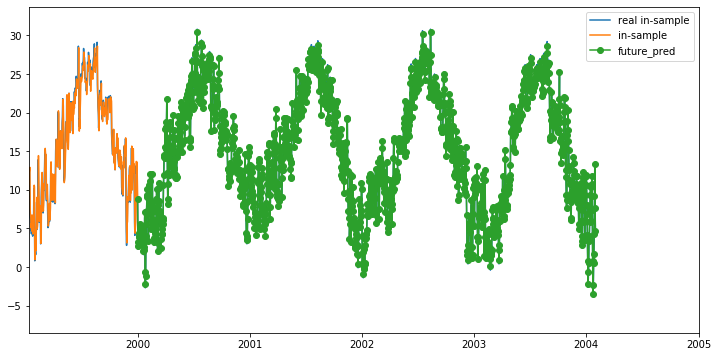

In [445]:
# Plot the three plots
plt.figure(figsize=(12,6))
plt.plot(df_istanbul.Real_temp, label='real in-sample')
plt.plot(res_T.predict(), label='in-sample' )
plt.plot(y_test_temp.index, predictions,  marker = 'o',label='future_pred')
plt.xlim(('01-12-1999', '01-01-2005'))
plt.legend()

Figure(432x288)


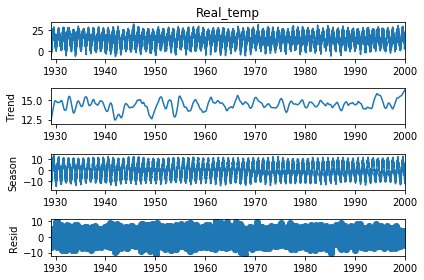

In [266]:
# Do a automatic decomposition
from statsmodels.tsa.seasonal import STL

decompose = STL(y_train_temp, period = 365)
decompose = decompose.fit()
print(decompose.plot())

Figure(432x288)


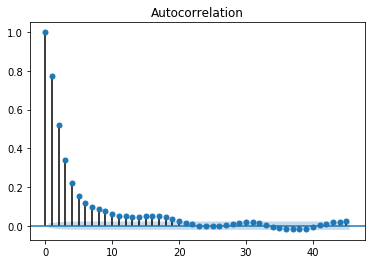

In [267]:
# Take the residuals for the analysis
series = decompose.resid
print(plot_acf(series))

Figure(432x288)


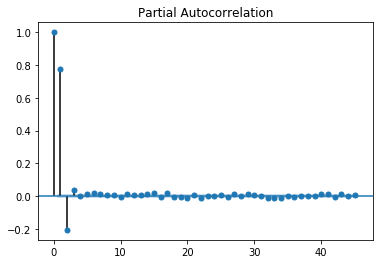

In [268]:
print(plot_pacf(series))

In [269]:
# Fit the model on the residuals
series_model = AutoReg(series, lags=2)
res_t_r = series_model.fit()
print(res_t_r.summary())

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                25933
Model:                     AutoReg(2)   Log Likelihood              -47378.764
Method:               Conditional MLE   S.D. of innovations              1.504
Date:                Wed, 29 Apr 2020   AIC                              0.817
Time:                        21:19:39   BIC                              0.818
Sample:                    01-03-1929   HQIC                             0.817
                         - 01-01-2000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.009      0.031      0.976      -0.018       0.019
resid.L1       0.9356      0.006    154.002      0.000       0.924       0.948
resid.L2      -0.2070      0.006    -34.077      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [270]:
# reconstruct the values
pr = res_t_r.fittedvalues + decompose.seasonal + decompose.trend

(729766.0, 731947.0)

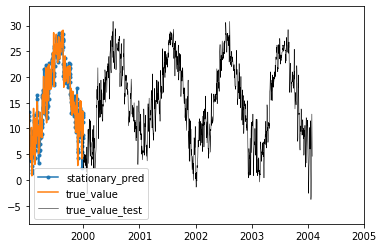

In [271]:
# Plot everything together
plt.plot(pr, label='stationary_pred', marker = 'o', markersize = 3)
plt.plot(y_train_temp, label='true_value')
plt.plot(y_test_temp, label='true_value_test', color = 'black', linewidth = .5 )
plt.legend()
plt.xlim(('01-12-1999', '01-01-2005'))


###  ARIMA

Figure(432x288)


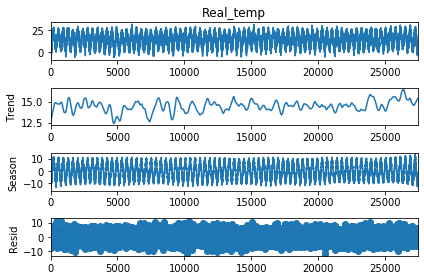

In [378]:
decompose = STL(df_istanbul['Real_temp'], period = 367, seasonal=13)
decompose = decompose.fit()
print(decompose.plot())

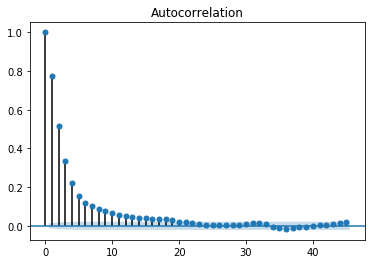

In [379]:
plot_acf(decompose.resid)
None

In [402]:
y_train = decompose.resid[:-300]
y_test = decompose.resid[-300:]

In [403]:
y_train

0        3.967068
1        3.284838
2        3.401620
3        3.538416
4        3.618315
5        2.678225
6       -1.023654
7       -1.023184
8       -2.148359
9       -5.025333
10      -4.435599
11      -3.450933
12      -1.905148
13      -2.207679
14       3.691251
15       6.751662
16       7.519317
17       3.406571
18      -0.131441
19       0.618269
20       0.182429
21      -1.630389
22      -1.106829
23      -2.434115
24      -2.803490
25       0.057684
26       4.314626
27       3.852829
28       4.834428
29      -0.337107
           ...   
27094   -5.226007
27095   -6.302325
27096   -4.245821
27097   -2.620689
27098   -1.528643
27099   -0.750359
27100   -2.095377
27101   -3.680197
27102   -3.081757
27103   -2.445411
27104   -2.263019
27105   -2.048616
27106   -1.550035
27107   -3.151220
27108   -4.802086
27109   -6.026444
27110   -5.997373
27111   -3.226376
27112   -0.306663
27113    0.799676
27114    1.136967
27115   -0.494969
27116   -2.193440
27117   -1.846014
27118   -0

In [404]:
fc= []
for i in range(300):
    #reinitialize the model
    ytrain = decompose.resid[:-300+i]
    m = ARIMA(ytrain, (2, 0, 0))
    m.initialize()
    r = m.fit()
    #do a forecast 5 periods ahead
    #collect the last forecasted point
    ypred, err, conf = r.forecast(steps=1)
    fc.append(ypred[-1])
    

(27000, 27500)

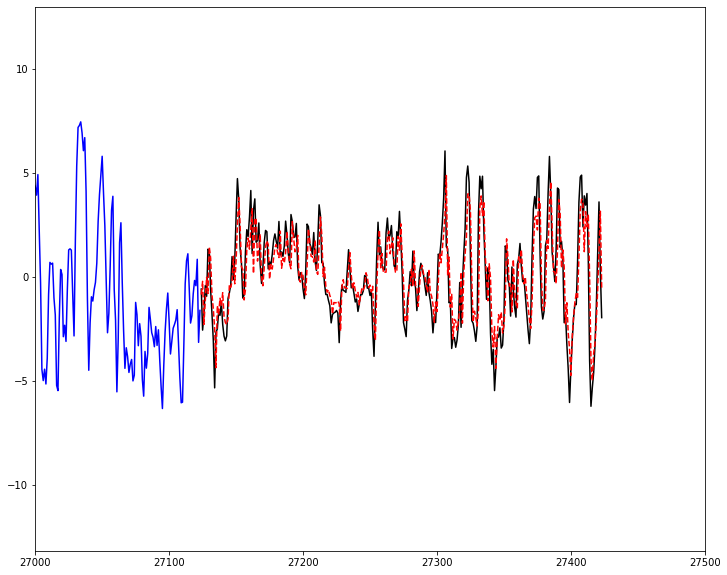

In [405]:
plt.figure(figsize=(12, 10))
plt.plot(y_train, color='blue')
plt.plot( y_test, color='black')
plt.plot( y_test.index, fc, ls = '--', color='red')
plt.xlim((27000, 27500))

In [408]:
# Compare the mean_squared_error of the two approaches
print(f'ARIMA time series: {mean_squared_error(y_test, fc)}')
print(f'Non-Stat. time series: {mean_squared_error(y_test_temp, predictions)}')


ARIMA time series: 1.7255381036973658
ARIMA time series: 0.13589427105288193
